In [35]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

#MODEL PREDICTS
print("#################### EVALUTATION ####################")
#model = tf.keras.models.load_model("../training/model/trained_model.h5")
# Read data
RA50_Model="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/cnn_acc85.0_auc0.9.h5"
RA50_Data="/mnt/0A60B2CB60B2BD2F/Projects/flow_regime_recognition_CameraPosition/datasets_preprocessed/RightAngled50/2022-11-08 17:34:40.437549/tf_dataset_test.tf"

path_model=RA50_Model
path_tf_dataset_test=RA50_Data

model_built = tf.keras.models.load_model(path_model)
# Read data
#load example picture
# Evaluate model
model_built.compile(loss='categorical_crossentropy', metrics='categorical_accuracy')

tf_dataset_test = tf.data.experimental.load(path_tf_dataset_test)
results = model_built.evaluate(tf_dataset_test, verbose=True)
print(f"Best Weights Evaluation: loss {results[0]}, acc {results[1]}")
x_test = []
y_test = []
for image, label in list(tf_dataset_test.unbatch().as_numpy_iterator()):
  tf_image=tf.convert_to_tensor(image)
  tf_image_batched=tf.expand_dims(tf_image, axis=0)
  x_test.append(tf_image_batched)
  y_test.append(label)
y_test_idx = tf.argmax(y_test, axis=1)

print("### PREDICT TEST DATASET FOR CONSUFION MATRIX ###")
predictions = [model_built.predict_on_batch(x) for x in x_test]

#################### EVALUTATION ####################
3/3 [==============================] - 0s 12ms/step - loss: 0.4755 - categorical_accuracy: 0.8548
Best Weights Evaluation: loss 0.47549355030059814, acc 0.8547717928886414
### PREDICT TEST DATASET FOR CONSUFION MATRIX ###


Confusion Matrix: tf.Tensor(
[[259  36   0   0]
 [ 34 235  20   0]
 [  1  45 242  20]
 [  0   0  19 294]], shape=(4, 4), dtype=int32)
Macro ROC AUC score: 0.9029171286680178
Macro ROC AUC score: 0.9031811894882433


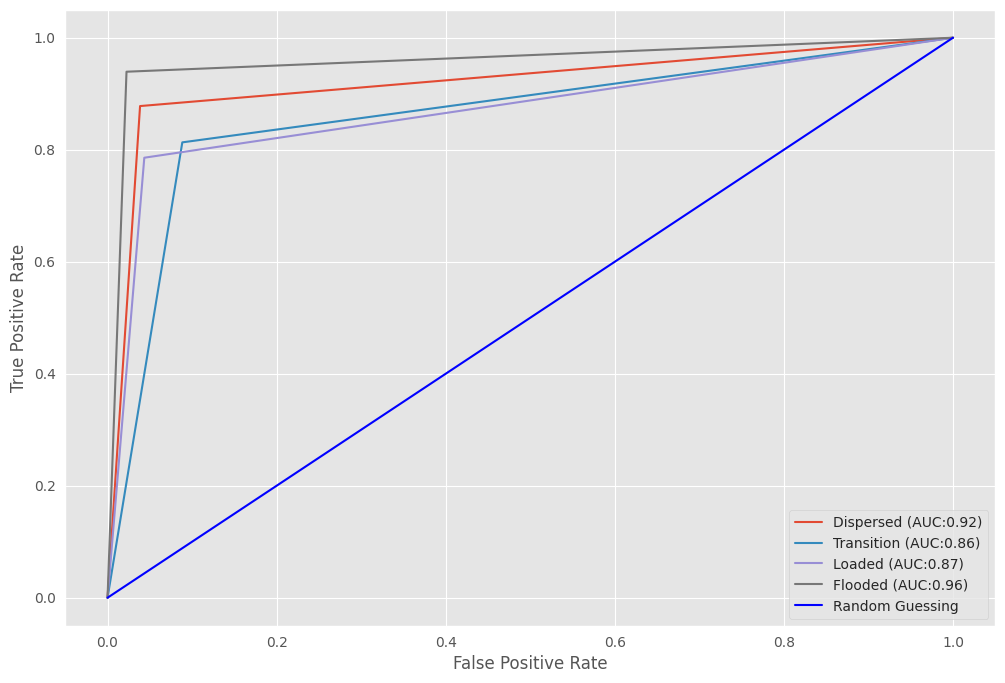

In [40]:


plt.rcParams['axes.grid'] = False
#fivethirtyeight
plt.style.use('ggplot')
predictions_mat = np.vstack(predictions)
predictions_idx = np.argmax(predictions_mat, axis=1)

conf_mat = tf.math.confusion_matrix(y_test_idx, predictions_idx)
print("Confusion Matrix: " + str(conf_mat))

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

target = ['Dispersed', 'Transition', 'Loaded', 'Flooded']
# set plot figure size
fig, c_ax = plt.subplots(1, 1, figsize=(12, 8))

# function for scoring roc auc score for multi-class

lb = LabelBinarizer()
lb.fit(y_test)
y_test = lb.transform(y_test_idx)
y_pred = lb.transform(predictions_idx)
for (idx, c_label) in enumerate(target):
  fpr, tpr, thresholds = roc_curve(y_test[:,idx], y_pred[:,idx])
  c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.plot(fpr, fpr, 'b-', label='Random Guessing')
auc=roc_auc_score(y_test, y_pred, average="macro")
print('Macro ROC AUC score:',auc)
auc=roc_auc_score(y_test, y_pred, average="micro")
print('Macro ROC AUC score:',auc)
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()
##########y
# Compute ROC curve and ROC area for each class

In [37]:

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(y_test, classes=["Dispersed", "Transition", "Loaded","Flooded"])
n_classes=4
for (i, classname) in enumerate(target):
  fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], predictions_mat[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

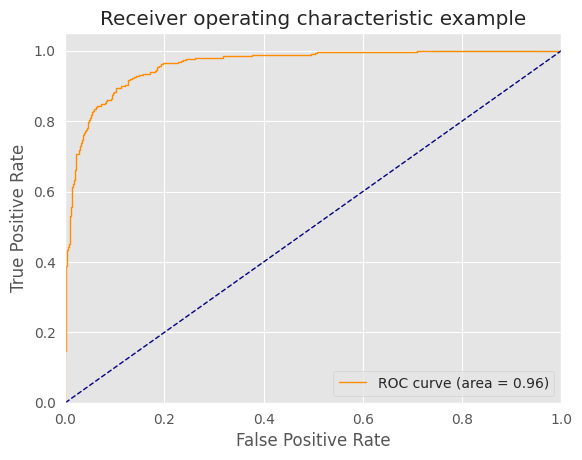

In [38]:

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 1
plt.plot(
  fpr[2],
  tpr[2],
  color="darkorange",
  lw=lw,
  label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])



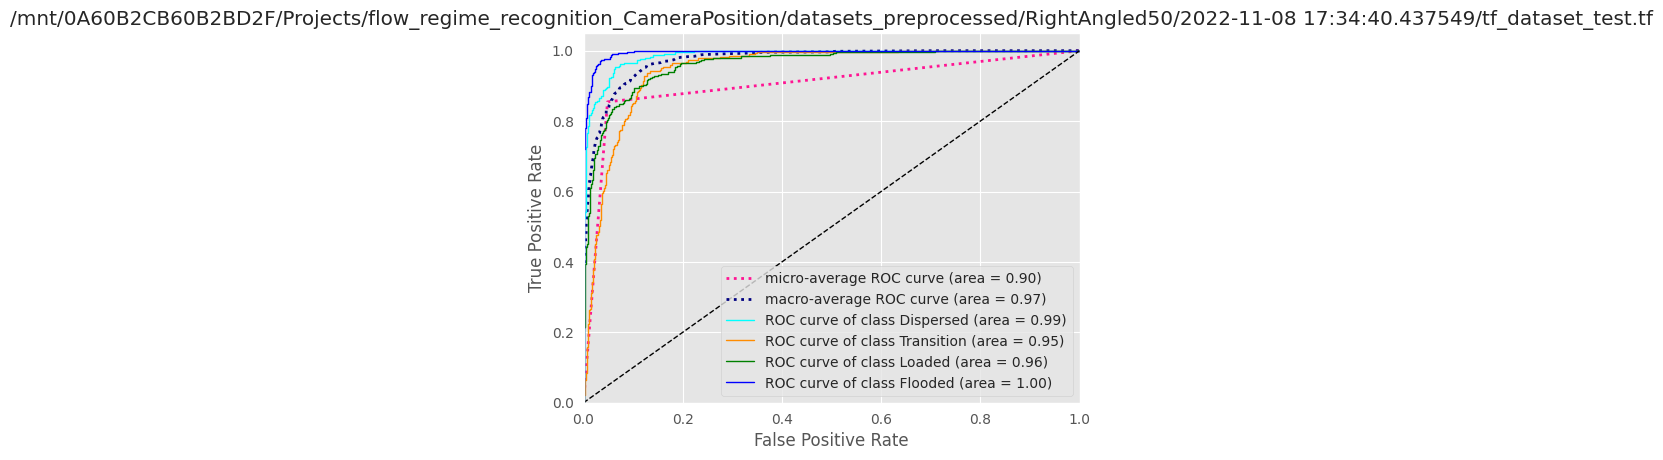

In [39]:
# Plot all ROC curves
plt.figure()
plt.plot(
  fpr["micro"],
  tpr["micro"],
  label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
  color="deeppink",
  linestyle=":",
  linewidth=2,
)

plt.plot(
  fpr["macro"],
  tpr["macro"],
  label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
  color="navy",
  linestyle=":",
  linewidth=2,
)
import matplotlib.pyplot as plt
from itertools import cycle
colors = cycle(["aqua", "darkorange", "green","blue"])
for i, color in zip(range(n_classes), colors):
  plt.plot(
    fpr[i],
    tpr[i],
    color=color,
    lw=lw,
    label=f"ROC curve of class {target[i]} "+"(area = {1:0.2f})".format(i, roc_auc[i]),
  )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(path_tf_dataset_test)
plt.legend(loc="lower right")
plt.savefig(f"{path_tf_dataset_test}/Roc.png")
plt.show()